In [176]:
%matplotlib inline
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from datetime import timedelta
import re

In [177]:
output_file = '/global/cscratch1/sd/crjones/taskfarmer/tasks.txt'
input_file_dir = '/global/project/projectdirs/m3312/crjones/e3sm/early_science/3hourly_3d_hist'
input_file_list = glob(f'{input_file_dir}/*.nc')

In [182]:
input_file_list[0]

'/global/project/projectdirs/m3312/crjones/e3sm/early_science/3hourly_3d_hist/earlyscience.FC5AV1C-H01A.ne120.sp1_64x1_1000m.20190329.cam.h2.0005-03-31-00000.nc'

In [188]:
re.findall('(\d+-\d+-\d+-\d+)', input_file_list[0])

['0005-03-31-00000']

In [192]:
output_file = '/global/cscratch1/sd/crjones/taskfarmer/tasks.txt'
input_file_dir = '/global/project/projectdirs/m3312/crjones/e3sm/early_science/3hourly_3d_hist'
input_file_list = glob(f'{input_file_dir}/*.nc')

model = 'mmf'
cmd = '$SCRATCH/taskfarmer/wrapper.sh'
with open(output_file, 'w') as file_out:
    file_out.write('#!/usr/bin/env bash\n\n')
    for this_file in sorted(input_file_list):
        date = re.findall('(\d+-\d+-\d+-\d+)', this_file)[0]
        file_out.write(f'{cmd} {date} {model}\n')

In [61]:
ds = xr.open_dataset('/global/cscratch1/sd/crjones/tmp/e3sm_merged_mcs_track.nc')
ds

<xarray.Dataset>
Dimensions:               (lat: 120, lon: 320, pressure: 1, time: 1960)
Coordinates:
  * lon                   (lon) float64 220.1 220.4 220.6 ... 299.4 299.6 299.9
  * lat                   (lat) float64 20.12 20.38 20.62 ... 49.38 49.62 49.88
  * pressure              (pressure) int64 850
  * time                  (time) datetime64[ns] 2002-03-01 ... 2002-10-31T21:00:00
Data variables:
    U                     (time, pressure, lat, lon) float32 ...
    V                     (time, pressure, lat, lon) float32 ...
    Q                     (time, pressure, lat, lon) float32 ...
    base_time             (time) datetime64[ns] ...
    julian_day            (time) float64 ...
    longitude             (time, lat, lon) float32 ...
    latitude              (time, lat, lon) float32 ...
    numclouds             (time) int32 ...
    tb                    (time, lat, lon) float32 ...
    precipitation         (time, lat, lon) float32 ...
    cloudtype             (time, lat, lon) float32 ...
    convcold_cloudnumber  (time, lat, lon) float32 ...
    cloudnumber           (time, lat, lon) float64 ...
    cloudtracknumber      (time, lat, lon) float64 ...
    pcptracknumber        (time, lat, lon) float64 ...

In [75]:
ds_land = xr.open_dataset('/global/project/projectdirs/m3312/crjones/e3sm/ne120_landfrac_720x1440.nc')

In [88]:
landmask = ds_land['LANDFRAC'].sel(lat=ds_combo.lat, lon=ds_combo.lon) > 0.9

In [89]:
ds.coords['landmask'] = landmask

In [97]:
mcs_mask = np.isfinite(ds.cloudtracknumber)

In [98]:
ds['mcs_mask'] = mcs_mask

In [154]:
ds['mcs_precipitation'] = ds['precipitation'].where(ds.mcs_mask)

In [99]:
ds

<xarray.Dataset>
Dimensions:               (lat: 120, lon: 320, pressure: 1, time: 1960)
Coordinates:
  * lon                   (lon) float64 220.1 220.4 220.6 ... 299.4 299.6 299.9
  * lat                   (lat) float64 20.12 20.38 20.62 ... 49.38 49.62 49.88
  * pressure              (pressure) int64 850
  * time                  (time) datetime64[ns] 2002-03-01 ... 2002-10-31T21:00:00
    landmask              (lat, lon) bool False False False ... False False
Data variables:
    U                     (time, pressure, lat, lon) float32 ...
    V                     (time, pressure, lat, lon) float32 ...
    Q                     (time, pressure, lat, lon) float32 ...
    base_time             (time) datetime64[ns] 2002-03-01 ... 2002-10-31T21:00:00
    julian_day            (time) float64 2.452e+06 2.452e+06 ... 2.453e+06
    longitude             (time, lat, lon) float32 ...
    latitude              (time, lat, lon) float32 ...
    numclouds             (time) int32 28 31 23 28 24 24 ... 27 31 29 33 27 32
    tb                    (time, lat, lon) float32 ...
    precipitation         (time, lat, lon) float32 ...
    cloudtype             (time, lat, lon) float32 ...
    convcold_cloudnumber  (time, lat, lon) float32 ...
    cloudnumber           (time, lat, lon) float64 ...
    cloudtracknumber      (time, lat, lon) float64 nan nan nan ... nan nan nan
    pcptracknumber        (time, lat, lon) float64 ...
    mcs_mask              (time, lat, lon) bool False False ... False False

In [ ]:
# select on MCS to scatter q vs v

In [101]:
q_mcs = ds['Q'].where(landmask & mcs_mask)
v_mcs = ds['V'].where(landmask & mcs_mask)

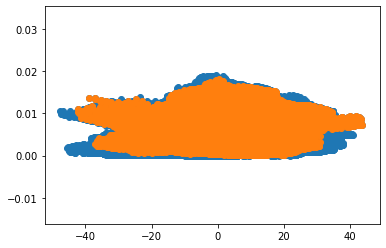

In [104]:
plt.scatter(ds['V'].where(landmask).values.flat, ds['Q'].where(landmask).values.flat)
plt.scatter(v_mcs.values.flat, q_mcs.values.flat)

## Binned by q and lat

In [ ]:
the_qbins = np.arange(0, 0.02, 0.0005)
res = np.zeros((len(ds.lat), len(the_qbins)))
for i, (label, lat_group) in enumerate(ds.where(ds.landmask).groupby('lat')):
    for j, (lab2, q_group) in enumerate(lat_group.groupby_bins(lat_group['Q'], bins=the_qbins)):
        res[i, j] = q_group['mcs_mask'].mean()

In [169]:
the_vbins

array([-33])

(array([], dtype=float64), array([-33]), <a list of 0 Patch objects>)

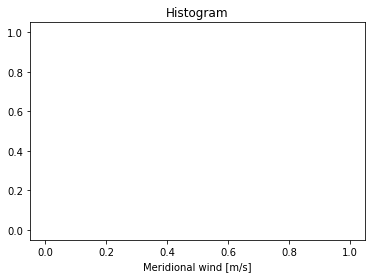

In [168]:
ds['V'].where(ds.landmask).plot.hist(bins=the_vbins)

In [171]:
the_qbins = np.arange(0, 0.02, 0.0005)
the_vbins = np.arange(-35, 37, 2)

mcs_freq = np.zeros((len(the_vbins), len(the_qbins)))
mcs_mean_precip = np.zeros((len(the_vbins), len(the_qbins)))

for i, (label, v_group) in enumerate(ds.where(ds.landmask).groupby_bins(ds['V'].where(ds.landmask), bins=the_vbins)):
    for j, (lab2, q_group) in enumerate(v_group.groupby_bins(v_group['Q'], bins=the_qbins)):
        mcs_freq[i, j] = q_group['mcs_mask'].mean()
        mcs_mean_precip[i, j] = q_group['mcs_precipitation'].mean()

/global/homes/c/crjones/.conda/envs/spe3sm_env/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [172]:
q = the_qbins + 0.00025
v = the_vbins + 1

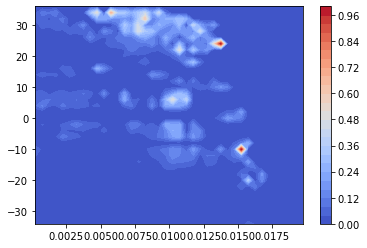

In [174]:
plt.contourf(q, v, mcs_freq, levels=30, cmap=plt.cm.coolwarm)
plt.colorbar()

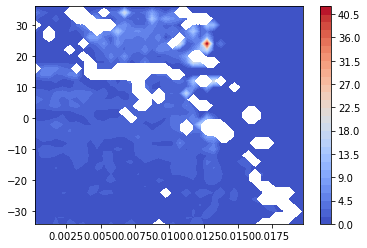

In [175]:
plt.contourf(q, v, mcs_mean_precip, levels=30, cmap=plt.cm.coolwarm)
plt.colorbar()

In [166]:
v_group

NameError: name 'v_group' is not defined

In [141]:
ds.lat.shape

(120,)

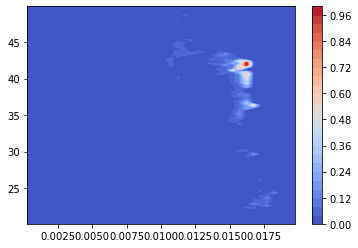

In [152]:
y = the_qbins + 0.00025
plt.contourf(y, ds.lat.values, res, levels=30, cmap=plt.cm.coolwarm)
plt.colorbar()

In [130]:
group

<xarray.Dataset>
Dimensions:                        (stacked_time_pressure_lat_lon: 821881)
Coordinates:
    landmask                       (stacked_time_pressure_lat_lon) bool True ... True
  * stacked_time_pressure_lat_lon  (stacked_time_pressure_lat_lon) MultiIndex
  - time                           (stacked_time_pressure_lat_lon) datetime64[ns] 2002-03-01 ... 2002-10-31T21:00:00
  - pressure                       (stacked_time_pressure_lat_lon) int64 850 ... 850
  - lat                            (stacked_time_pressure_lat_lon) float64 20.12 ... 31.12
  - lon                            (stacked_time_pressure_lat_lon) float64 255.1 ... 255.1
Data variables:
    U                              (stacked_time_pressure_lat_lon) float32 4.5006394 ... 2.7714095
    V                              (stacked_time_pressure_lat_lon) float32 -5.129878 ... 8.178745
    Q                              (stacked_time_pressure_lat_lon) float32 0.0077168816 ... 0.007684444
    base_time                      (stacked_time_pressure_lat_lon) datetime64[ns] 2002-03-01 ... 2002-10-31T21:00:00
    julian_day                     (stacked_time_pressure_lat_lon) float64 2.452e+06 ... 2.453e+06
    longitude                      (stacked_time_pressure_lat_lon) float32 255.125 ... 255.125
    latitude                       (stacked_time_pressure_lat_lon) float32 20.125 ... 31.125
    numclouds                      (stacked_time_pressure_lat_lon) float64 28.0 ... 32.0
    tb                             (stacked_time_pressure_lat_lon) float32 303.55017 ... 293.70795
    precipitation                  (stacked_time_pressure_lat_lon) float32 0.0 ... 3.6813394e-13
    cloudtype                      (stacked_time_pressure_lat_lon) float32 nan ... nan
    convcold_cloudnumber           (stacked_time_pressure_lat_lon) float32 nan ... nan
    cloudnumber                    (stacked_time_pressure_lat_lon) float64 nan ... nan
    cloudtracknumber               (stacked_time_pressure_lat_lon) float64 nan ... nan
    pcptracknumber                 (stacked_time_pressure_lat_lon) float64 nan ... nan
    mcs_mask                       (stacked_time_pressure_lat_lon) float64 0.0 ... 0.0

In [128]:
group['mcs_mask'].sum()

<xarray.DataArray 'mcs_mask' ()>
array(4658.)

In [129]:
group['mcs_mask'].mean(dim=['lon', 'time'])

<xarray.DataArray 'mcs_mask' ()>
array(0.00566749)

In [126]:
ds = ds.squeeze().load()

In [121]:
result = []
for label, group in qbins:
    result.append(ds['mcs_mask'].isel(group).mean())

ValueError: dimensions {'Q', 'base_time', 'numclouds', 'convcold_cloudnumber', 'cloudnumber', 'mcs_mask', 'tb', 'V', 'longitude', 'precipitation', 'U', 'cloudtracknumber', 'pcptracknumber', 'latitude', 'cloudtype', 'julian_day'} do not exist

In [112]:
# group by q:
qbins2 = ds['Q'].where(ds.landmask).groupby_bins(ds['Q'].where(landmask), bins=50)

In [127]:
qbins = ds['Q'].squeeze().groupby_bins(ds['Q'].where(landmask), bins=50)

TypeError: 'DatasetGroupBy' object is not subscriptable

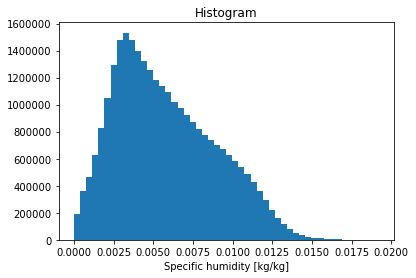

In [111]:
ds['Q'].where(landmask).plot.hist(bins=50)
qbins['Q'].count().plot()

(array([2.470958e+06, 6.828408e+06, 6.295624e+06, 4.881280e+06,
        3.703592e+06, 2.664849e+06, 1.142280e+06, 2.071310e+05,
        2.793600e+04, 1.582000e+03]),
 array([6.5505827e-07, 1.9189585e-03, 3.8372620e-03, 5.7555656e-03,
        7.6738689e-03, 9.5921727e-03, 1.1510476e-02, 1.3428779e-02,
        1.5347083e-02, 1.7265387e-02, 1.9183690e-02], dtype=float32),
 <a list of 10 Patch objects>)

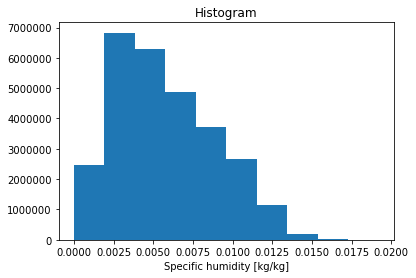

In [105]:
ds['Q'].where(landmask).plot()

(array([4.8400000e+02, 7.3750000e+03, 9.8333000e+04, 1.5541240e+06,
        8.5841240e+06, 1.3473128e+07, 3.8752170e+06, 5.7339800e+05,
        5.6411000e+04, 1.0460000e+03]),
 array([-47.633423, -38.527897, -29.42237 , -20.316845, -11.211319,
         -2.105793,   6.999733,  16.105259,  25.210785,  34.31631 ,
         43.421837], dtype=float32),
 <a list of 10 Patch objects>)

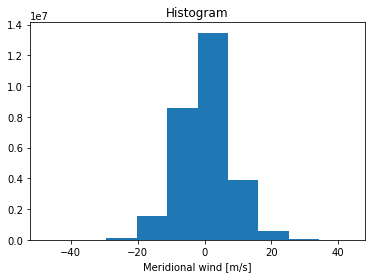

In [100]:
ds['V'].where(landmask).plot()

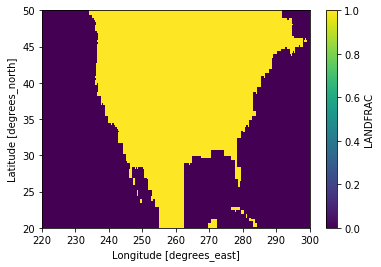

In [87]:
landmask.plot()

In [ ]:
# add land mask and mcs mask

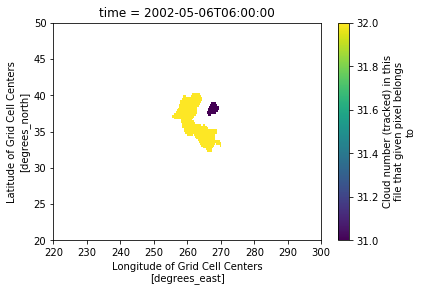

In [72]:
ds['cloudtracknumber'].isel(time=530).plot()

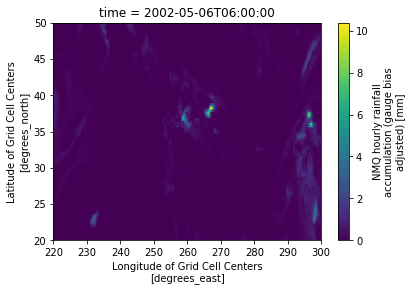

In [74]:
ds['precipitation'].isel(time=530).plot()

In [3]:
# Work on binning some stuff
da = xr.DataArray(np.random.rand(5, 10, 12), name='dummy')

In [4]:
da

<xarray.DataArray 'dummy' (dim_0: 5, dim_1: 10, dim_2: 12)>
array([[[0.67474194, 0.55535561, 0.47069908, 0.96182843, 0.42289892,
         0.79129957, 0.1115272 , 0.1713446 , 0.37700602, 0.86382318,
         0.21721045, 0.55420596],
        [0.80523113, 0.83399151, 0.78321435, 0.597901  , 0.14645279,
         0.9727993 , 0.816567  , 0.3053286 , 0.17622749, 0.26659231,
         0.47381763, 0.5240322 ],
        [0.95675496, 0.99883425, 0.58839998, 0.34862054, 0.92895481,
         0.10253706, 0.35302028, 0.43926854, 0.72179185, 0.88144752,
         0.18054007, 0.71703516],
        [0.43037134, 0.61066984, 0.68683051, 0.40429148, 0.1090534 ,
         0.0495586 , 0.60970178, 0.68123766, 0.54798443, 0.17990596,
         0.57683502, 0.99575548],
        [0.93691806, 0.79117008, 0.43306321, 0.12794843, 0.47659294,
         0.41506385, 0.82867755, 0.31934857, 0.54787642, 0.57918322,
         0.36944588, 0.60509086],
        [0.6006689 , 0.02538294, 0.00738434, 0.66673009, 0.80873198,
         0.51751824, 0.01560538, 0.41064273, 0.29311785, 0.85662727,
         0.76449283, 0.58952031],
        [0.6066983 , 0.01663383, 0.46975158, 0.82544011, 0.14755733,
         0.89761711, 0.42210503, 0.19554244, 0.9638875 , 0.04940026,
         0.4431569 , 0.39122525],
        [0.26052552, 0.95431317, 0.30883728, 0.10983945, 0.46375863,
         0.40012785, 0.15753289, 0.02555097, 0.75701622, 0.78794275,
         0.9297891 , 0.19688824],
        [0.89020131, 0.2960752 , 0.52123443, 0.01413387, 0.21431443,
         0.6234104 , 0.62645119, 0.55941863, 0.11442624, 0.83258522,
         0.19685892, 0.68236823],
        [0.76661102, 0.0222544 , 0.30141179, 0.44351897, 0.78023528,
         0.49836022, 0.9307725 , 0.49050154, 0.45350273, 0.93955232,
         0.42023738, 0.86902991]],

       [[0.35515988, 0.69644327, 0.50062838, 0.62834232, 0.2102373 ,
         0.50749775, 0.46888548, 0.01373998, 0.49812609, 0.89369236,
         0.39015865, 0.60752701],
        [0.71055347, 0.26858411, 0.48672744, 0.01182314, 0.51066525,
         0.34954258, 0.99108943, 0.41300993, 0.66984888, 0.78892031,
         0.45009625, 0.20759237],
        [0.93023189, 0.54338946, 0.46382995, 0.44417493, 0.45428535,
         0.86295088, 0.08181298, 0.32269225, 0.33205331, 0.27839527,
         0.17724091, 0.54350716],
        [0.82643232, 0.64979211, 0.49254108, 0.12180662, 0.98703355,
         0.83957169, 0.08433088, 0.23715531, 0.26357946, 0.90059636,
         0.50420057, 0.95897892],
        [0.50934524, 0.21533027, 0.65313539, 0.28528664, 0.91192401,
         0.38240433, 0.62499445, 0.25362032, 0.86574343, 0.70902411,
         0.77581086, 0.99997973],
        [0.71246244, 0.36192357, 0.30488335, 0.18632189, 0.23359024,
         0.55900236, 0.24007331, 0.41592312, 0.69223448, 0.25836221,
         0.63734221, 0.69463305],
        [0.42435471, 0.49296915, 0.8199403 , 0.69925345, 0.1697647 ,
         0.57780276, 0.96924252, 0.33287726, 0.23174864, 0.04920175,
         0.78368966, 0.51706638],
        [0.10190836, 0.5322396 , 0.29992187, 0.13705745, 0.10646498,
         0.19478692, 0.12982253, 0.41792642, 0.00466162, 0.94513445,
         0.19453236, 0.41186436],
        [0.19422196, 0.02120318, 0.70604343, 0.25720832, 0.36791473,
         0.33898499, 0.66218396, 0.61467683, 0.61582094, 0.37205735,
         0.04793317, 0.65496783],
        [0.19535044, 0.03777652, 0.89575064, 0.84013225, 0.08609369,
         0.20063148, 0.48411749, 0.9574819 , 0.3225637 , 0.61390634,
         0.08720611, 0.95757915]],

       [[0.33376896, 0.17321109, 0.76969518, 0.26985567, 0.38143661,
         0.21122848, 0.75754734, 0.13485706, 0.63851263, 0.56918749,
         0.61983722, 0.74243562],
        [0.88685416, 0.99231546, 0.61743419, 0.07074753, 0.27313065,
         0.29212778, 0.98564656, 0.12493984, 0.87598824, 0.49304551,
         0.9258188 , 0.23077912],
        [0.41516182, 0.72125308, 0.14353596, 0.66228775, 0.01416626,
         0.1404226 , 0.20243892, 0.65391051, 0.30083446, 0.65872112,
         0.573

In [9]:
da.groupby_bins(da, bins=10)

DataArrayGroupBy, grouped over 'dummy_bins' 
10 groups with labels (0.602,, 0.701], ..., (0.00287,, 0.103].

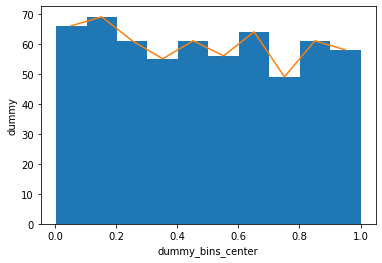

In [14]:
da.plot.hist(bins=10)
da.groupby_bins(da, bins=10).count().plot()

In [17]:
# conveniently you can group by the dataArray itself (xarray is nice)
ds_e3sm = xr.open_mfdataset(glob('/global/project/projectdirs/m3312/crjones/e3sm/early_science_e3sm/3hourly_3d_hist/conus/daily/tmp/earlyscience.FC5AV1C-H01A.ne120.E3SM.850hpa.0002-[01][03456789]-*.nc'),
                            combine='by_coords')

In [18]:
ds_e3sm

<xarray.Dataset>
Dimensions:   (lat: 120, lon: 320, pressure: 1, time: 1960)
Coordinates:
  * lon       (lon) float64 220.1 220.4 220.6 220.9 ... 299.1 299.4 299.6 299.9
  * lat       (lat) float64 20.12 20.38 20.62 20.88 ... 49.12 49.38 49.62 49.88
  * pressure  (pressure) int64 850
  * time      (time) object 0002-03-01 00:00:00 ... 0002-10-31 21:00:00
Data variables:
    U         (time, pressure, lat, lon) float32 dask.array<chunksize=(8, 1, 120, 320), meta=np.ndarray>
    V         (time, pressure, lat, lon) float32 dask.array<chunksize=(8, 1, 120, 320), meta=np.ndarray>
    Q         (time, pressure, lat, lon) float32 dask.array<chunksize=(8, 1, 120, 320), meta=np.ndarray>
Attributes:
    ne:                        120
    np:                        4
    Conventions:               CF-1.0
    source:                    CAM
    case:                      earlyscience.FC5AV1C-H01A.ne120.E3SM.20190329
    title:                     UNSET
    logname:                   crjones
    host:                      cori11
    Version:                   $Name$
    revision_Id:               $Id$
    initial_file:              /project/projectdirs/acme/inputdata/atm/cam/in...
    topography_file:           /project/projectdirs/acme/inputdata/atm/cam/to...
    time_period_freq:          hour_3
    history:                   Thu Jun 25 16:50:57 2020: ncks -O -t 2 --no_tm...
    remap_script:              ncremap
    remap_hostname:            cori12
    remap_version:             4.9.4-alpha04
    NCO:                       netCDF Operators version 4.9.4-alpha04 (Homepa...
    nco_openmp_thread_number:  2
    map_file:                  /global/homes/z/zender/data/maps/map_ne120np4_...
    input_file:                /global/cfs/cdirs/m3312/crjones/e3sm/early_sci...

In [19]:
ds_track = xr.open_dataset('/global/cscratch1/sd/crjones/ECP/e3sm/mcstracking/20020301_20021031/mcstrack_20020301_0000.nc')

In [20]:
ds_track

<xarray.Dataset>
Dimensions:               (lat: 120, lon: 320, time: 1)
Coordinates:
  * time                  (time) datetime64[ns] 2002-03-01
  * lon                   (lon) float32 220.125 220.375 ... 299.625 299.875
  * lat                   (lat) float32 20.125 20.375 20.625 ... 49.625 49.875
Data variables:
    base_time             (time) datetime64[ns] ...
    julian_day            (time) float64 ...
    longitude             (lat, lon) float32 ...
    latitude              (lat, lon) float32 ...
    numclouds             (time) int32 ...
    tb                    (time, lat, lon) float32 ...
    precipitation         (time, lat, lon) float32 ...
    cloudtype             (time, lat, lon) float32 ...
    convcold_cloudnumber  (time, lat, lon) float32 ...
    cloudnumber           (time, lat, lon) float64 ...
    cloudtracknumber      (time, lat, lon) float64 ...
    pcptracknumber        (time, lat, lon) float64 ...
Attributes:
    title:       Robust MCS pixel-level tracking final output data
    comment1:    cloudtracknumber labels all cold cloud pixels identified as ...
    comment2:    tb, precipitation are full fields, use cloudtracknumber, pcp...
    startdate:   20020301
    enddate:     20021031
    contact:     Zhe Feng: zhe.feng@pnnl.gov
    created_on:  Mon Jun 17 20:28:40 2019

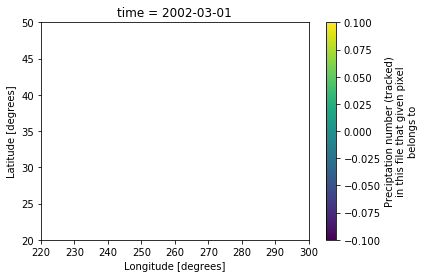

In [23]:
ds_track.pcptracknumber.squeeze().plot()

In [42]:
track_dir = '/global/project/projectdirs/m3312/crjones/ECP/e3sm/mcstracking/20020301_20021031'

In [43]:
hours = ['00', '03', '06', '09', '12', '15', '18', '21']

In [45]:
track_files = []
for h in hours:
    track_files.extend(glob(f'{track_dir}/mcstrack_*_{h}00.nc'))
print(len(track_files))

1960


In [46]:
ds_tracks = xr.open_mfdataset(sorted(track_files), combine='by_coords')

In [47]:
ds_tracks

<xarray.Dataset>
Dimensions:               (lat: 120, lon: 320, time: 1960)
Coordinates:
  * lon                   (lon) float32 220.125 220.375 ... 299.625 299.875
  * lat                   (lat) float32 20.125 20.375 20.625 ... 49.625 49.875
  * time                  (time) datetime64[ns] 2002-03-01 ... 2002-10-31T21:00:00
Data variables:
    base_time             (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    julian_day            (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    longitude             (time, lat, lon) float32 dask.array<chunksize=(1, 120, 320), meta=np.ndarray>
    latitude              (time, lat, lon) float32 dask.array<chunksize=(1, 120, 320), meta=np.ndarray>
    numclouds             (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    tb                    (time, lat, lon) float32 dask.array<chunksize=(1, 120, 320), meta=np.ndarray>
    precipitation         (time, lat, lon) float32 dask.array<chunksize=(1, 120, 320), meta=np.ndarray>
    cloudtype             (time, lat, lon) float32 dask.array<chunksize=(1, 120, 320), meta=np.ndarray>
    convcold_cloudnumber  (time, lat, lon) float32 dask.array<chunksize=(1, 120, 320), meta=np.ndarray>
    cloudnumber           (time, lat, lon) float64 dask.array<chunksize=(1, 120, 320), meta=np.ndarray>
    cloudtracknumber      (time, lat, lon) float64 dask.array<chunksize=(1, 120, 320), meta=np.ndarray>
    pcptracknumber        (time, lat, lon) float64 dask.array<chunksize=(1, 120, 320), meta=np.ndarray>
Attributes:
    title:       Robust MCS pixel-level tracking final output data
    comment1:    cloudtracknumber labels all cold cloud pixels identified as ...
    comment2:    tb, precipitation are full fields, use cloudtracknumber, pcp...
    startdate:   20020301
    enddate:     20021031
    contact:     Zhe Feng: zhe.feng@pnnl.gov
    created_on:  Tue Jul  2 07:23:22 2019

In [37]:
ds_e3sm.time

<xarray.DataArray 'time' (time: 1960)>
array([cftime.DatetimeNoLeap(0002-03-01 00:00:00),
       cftime.DatetimeNoLeap(0002-03-01 03:00:00),
       cftime.DatetimeNoLeap(0002-03-01 06:00:00), ...,
       cftime.DatetimeNoLeap(0002-10-31 15:00:00),
       cftime.DatetimeNoLeap(0002-10-31 18:00:00),
       cftime.DatetimeNoLeap(0002-10-31 21:00:00)], dtype=object)
Coordinates:
  * time     (time) object 0002-03-01 00:00:00 ... 0002-10-31 21:00:00
Attributes:
    long_name:  time
    bounds:     time_bnds

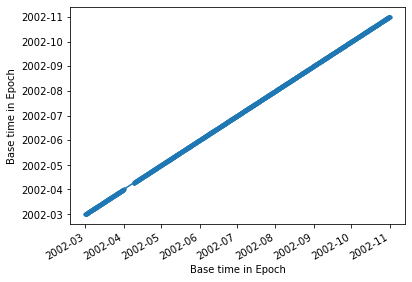

In [41]:
ds_tracks.time.plot(marker='.')

In [49]:
ds_e3sm['time'] = ds_e3sm['time'] + timedelta(days=365 * 2000)
ds_e3sm['time']

<xarray.DataArray 'time' (time: 1960)>
array([cftime.DatetimeNoLeap(2002-03-01 00:00:00),
       cftime.DatetimeNoLeap(2002-03-01 03:00:00),
       cftime.DatetimeNoLeap(2002-03-01 06:00:00), ...,
       cftime.DatetimeNoLeap(2002-10-31 15:00:00),
       cftime.DatetimeNoLeap(2002-10-31 18:00:00),
       cftime.DatetimeNoLeap(2002-10-31 21:00:00)], dtype=object)
Coordinates:
  * time     (time) object 2002-03-01 00:00:00 ... 2002-10-31 21:00:00

In [55]:
ds_e3sm['time'] = ds_tracks['time']

In [59]:
ds_combo = xr.merge([ds_e3sm, ds_tracks]).load()

In [60]:
ds_combo.to_netcdf('/global/cscratch1/sd/crjones/tmp/e3sm_merged_mcs_track.nc')

In [53]:
ds_tracks

<xarray.Dataset>
Dimensions:               (lat: 120, lon: 320, time: 1960)
Coordinates:
  * lon                   (lon) float32 220.125 220.375 ... 299.625 299.875
  * lat                   (lat) float32 20.125 20.375 20.625 ... 49.625 49.875
  * time                  (time) datetime64[ns] 2002-03-01 ... 2002-10-31T21:00:00
Data variables:
    base_time             (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    julian_day            (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    longitude             (time, lat, lon) float32 dask.array<chunksize=(1, 120, 320), meta=np.ndarray>
    latitude              (time, lat, lon) float32 dask.array<chunksize=(1, 120, 320), meta=np.ndarray>
    numclouds             (time) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    tb                    (time, lat, lon) float32 dask.array<chunksize=(1, 120, 320), meta=np.ndarray>
    precipitation         (time, lat, lon) float32 dask.array<chunksize=(1, 120, 320), meta=np.ndarray>
    cloudtype             (time, lat, lon) float32 dask.array<chunksize=(1, 120, 320), meta=np.ndarray>
    convcold_cloudnumber  (time, lat, lon) float32 dask.array<chunksize=(1, 120, 320), meta=np.ndarray>
    cloudnumber           (time, lat, lon) float64 dask.array<chunksize=(1, 120, 320), meta=np.ndarray>
    cloudtracknumber      (time, lat, lon) float64 dask.array<chunksize=(1, 120, 320), meta=np.ndarray>
    pcptracknumber        (time, lat, lon) float64 dask.array<chunksize=(1, 120, 320), meta=np.ndarray>
Attributes:
    title:       Robust MCS pixel-level tracking final output data
    comment1:    cloudtracknumber labels all cold cloud pixels identified as ...
    comment2:    tb, precipitation are full fields, use cloudtracknumber, pcp...
    startdate:   20020301
    enddate:     20021031
    contact:     Zhe Feng: zhe.feng@pnnl.gov
    created_on:  Tue Jul  2 07:23:22 2019